In [151]:
# Common imports
import sys
import os
import sklearn
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
column_names = [
    "age", "workclass", "fnlwgt", "education", "educationNum", "maritalStatus",
    "occupation", "relationship", "race", "sex", "capitalGain", "capitalLoss",
    "hoursPerWeek", "nativeCountry", "salary"
]

# Load the data into a pandas DataFrame
df = pd.read_csv(url, names=column_names, sep=',\s*', engine='python')

In [152]:
#Prepare data

#Replace ? with null/naan
df.replace("?", np.nan, inplace=True)

#Show rows with missing values to be removed
missing_values = df.isnull().sum()
print(missing_values)

#Remove missing values
df = df.dropna(how='any')



age                 0
workclass        1836
fnlwgt              0
education           0
educationNum        0
maritalStatus       0
occupation       1843
relationship        0
race                0
sex                 0
capitalGain         0
capitalLoss         0
hoursPerWeek        0
nativeCountry     583
salary              0
dtype: int64


In [153]:
from sklearn.preprocessing import LabelEncoder

# Initialize the labelEncoder variable
label_encoder = LabelEncoder()

# Define which columns to be transformed
columns_to_transform = ['age', 'workclass', 'fnlwgt', 'education', 'educationNum', 'maritalStatus', 'occupation', 'relationship', 'race', 'sex', 'capitalGain', 'capitalLoss', 'hoursPerWeek', 'nativeCountry', 'salary']

# Transform the values in the specified columns of the DataFrame into integer labels.
for column in columns_to_transform:
    if column in df.columns:
        df[column] = label_encoder.fit_transform(df[column])

Show the table

In [154]:
df

,age,workclass,fnlwgt,education,educationNum,maritalStatus,occupation,relationship,race,sex,capitalGain,capitalLoss,hoursPerWeek,nativeCountry,salary
0,22,5,2491,9,12,4,0,1,4,1,24,0,39,38,0
1,33,4,2727,9,12,2,3,0,4,1,0,0,12,38,0
2,21,2,13188,11,8,0,5,1,4,1,0,0,39,38,0
3,36,2,14354,1,6,2,5,0,2,1,0,0,39,38,0
4,11,2,18120,9,12,2,9,5,2,0,0,0,39,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,10,2,15471,7,11,2,12,5,4,0,0,0,37,38,0
32557,23,2,7555,11,8,2,6,0,4,1,0,0,39,38,1
32558,41,2,7377,11,8,6,0,4,4,0,0,0,39,38,0
32559,5,2,12060,11,8,4,0,3,4,1,0,0,19,38,0


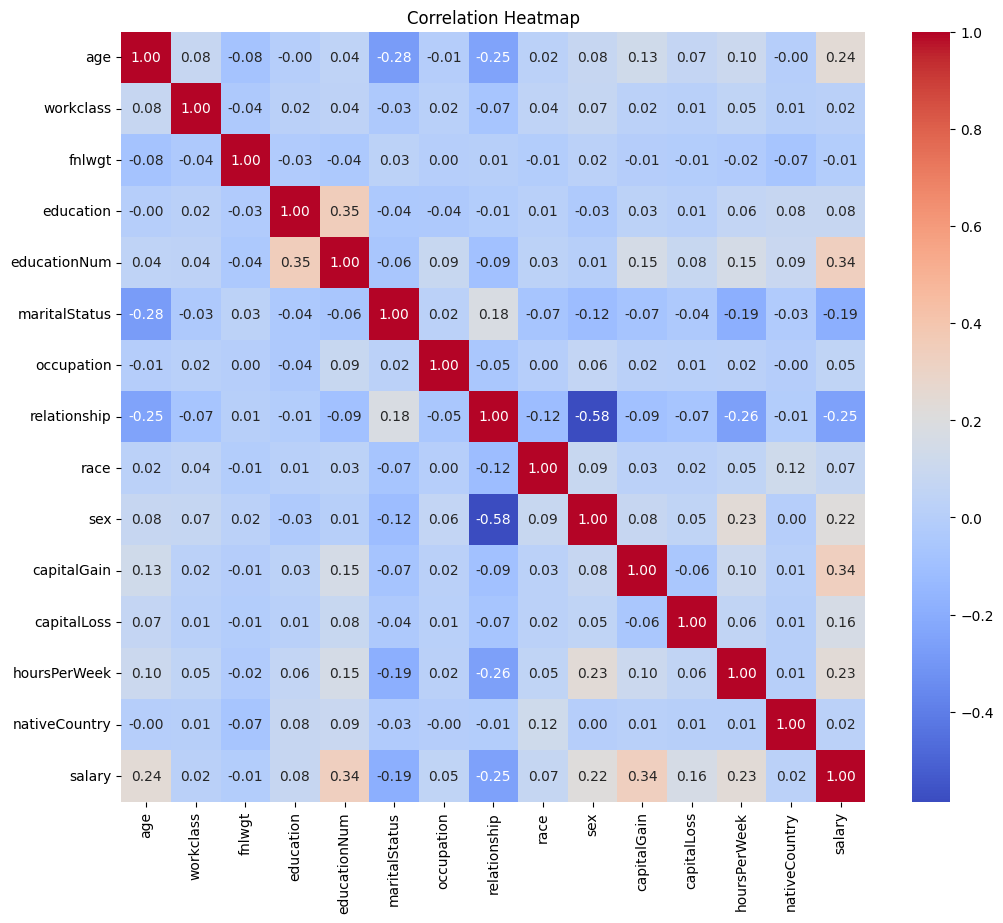

In [155]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
correlation_matrix = df.corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [156]:
#From the above correlation matrix remove the unneccesary column which have least significant correlation with the target varaible "Income
post_data_df = df.drop(['educationNum', 'nativeCountry', 'fnlwgt'],axis=1)
post_data_df

,age,workclass,education,maritalStatus,occupation,relationship,race,sex,capitalGain,capitalLoss,hoursPerWeek,salary
0,22,5,9,4,0,1,4,1,24,0,39,0
1,33,4,9,2,3,0,4,1,0,0,12,0
2,21,2,11,0,5,1,4,1,0,0,39,0
3,36,2,1,2,5,0,2,1,0,0,39,0
4,11,2,9,2,9,5,2,0,0,0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
32556,10,2,7,2,12,5,4,0,0,0,37,0
32557,23,2,11,2,6,0,4,1,0,0,39,1
32558,41,2,11,6,0,4,4,0,0,0,39,0
32559,5,2,11,4,0,3,4,1,0,0,19,0


In [157]:
#Split data
X = post_data_df.drop(columns=["sex"])
y = post_data_df["sex"]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

**Multilayer Perceptron (MLP)**

Creating the model

In [158]:
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(x_train.shape[1],)))

    # Tune the number of hidden layers and units in each layer
    for i in range(hp.Int('num_layers', min_value=1, max_value=4)):
        model.add(keras.layers.Dense(units=hp.Int('units_' + str(i),
                                                min_value=32, max_value=512,
                                                step=32),
                                  activation='relu'))

    model.add(keras.layers.Dense(10, activation='softmax'))  # 10 output classes for sparse categorical cross-entropy

    # Tune the learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

Preprocess the data

In [159]:
mlp_X_train = x_train;
mlp_X_test = x_test;
mlp_Y_train = y_train;
mlp_Y_test = y_test;

# Define a function to preprocess the data
def preprocess(X, y):
    X = tf.convert_to_tensor(X, dtype=tf.float32)
    y = tf.convert_to_tensor(y, dtype=tf.int64)  # Change data type to int64 for sparse_categorical_crossentropy
    return X, y

# Preprocess the data
mlp_X_train, mlp_Y_train = preprocess(mlp_X_train, mlp_Y_train)
mlp_X_test, mlp_Y_test = preprocess(mlp_X_test, mlp_Y_test)

Tuning the hyperparameters and training the model

In [160]:
# Initialize the Keras Tuner RandomSearch
import kerastuner as kt

random_search_tuner = kt.RandomSearch(
    build_model, objective='val_accuracy', max_trials=10, directory='my_mnist',
    project_name='my_rnd_search', seed=42)

# Search for the best hyperparameters by training and evaluating different model configurations
# using the Keras Tuner. Perform training epochs with the specified hyperparameters.
random_search_tuner.search(mlp_X_train, mlp_Y_train, validation_data=(mlp_X_test, mlp_Y_test), epochs=2)



Reloading Tuner from my_mnist/my_rnd_search/tuner0.json


Get the best model and hyper parameters

In [161]:
# Get the best model and hyperparameters
best_model = random_search_tuner.get_best_models(1)[0]
best_hyperparameters = random_search_tuner.get_best_hyperparameters(1)[0]

Evaluate the best model

In [162]:
test_loss, test_accuracy = best_model.evaluate(mlp_X_test, mlp_Y_test)

print(f'Test accuracy: {test_accuracy}')

189/189 [==============================] - 1s 2ms/step - loss: 0.3843 - accuracy: 0.8135
Test accuracy: 0.8135256171226501


Performance Monitoring and Improvement Analysis

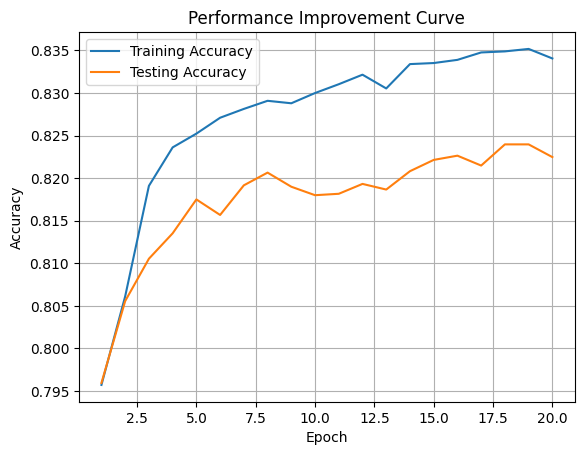

In [163]:
# Initialize lists to store training and testing performance over time
train_acc_over_time = []
test_acc_over_time = []

# Define the number of epochs
num_epochs = 20

# Train the model and record performance at each epoch
for epoch in range(num_epochs):
    best_model.fit(mlp_X_train, mlp_Y_train, epochs=1, verbose=0)
    train_loss, train_accuracy = best_model.evaluate(mlp_X_train, mlp_Y_train, verbose=0)
    test_loss, test_accuracy = best_model.evaluate(mlp_X_test, mlp_Y_test, verbose=0)

    train_acc_over_time.append(train_accuracy)
    test_acc_over_time.append(test_accuracy)

# Plot the PIT curve
epochs = np.arange(1, num_epochs + 1)
plt.plot(epochs, train_acc_over_time, label='Training Accuracy')
plt.plot(epochs, test_acc_over_time, label='Testing Accuracy')
plt.title('Performance Improvement Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

**Random Forest**

In [164]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import numpy as np

Creating a Random Forest classifier and fitting the model to the training data

In [165]:
# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_classifier.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

Tuning hyper parameters using RandomizedSearchCV

In [166]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [100, 1001, 100],
    'max_depth': [None, 10, 101, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 11],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    estimator=rf_classifier,
    param_distributions=param_dist,
    n_iter=10,
    n_jobs=-1,
    cv=5,
    verbose=1,
    random_state=42
)

Hyperparameter Search with RandomizedSearchCV

In [167]:
random_search.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 101, 10],
                                        'min_samples_leaf': [1, 11],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 1001, 100]},
                   random_state=42, verbose=1)

Get the best hyperparameters

In [168]:
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'n_estimators': 1001, 'min_samples_split': 2, 'min_samples_leaf': 11, 'max_depth': None, 'bootstrap': False}


Create a Random Forest model with the best hyperparameters

In [169]:
best_rf_classifier = RandomForestClassifier(**best_params, random_state=42)
best_rf_classifier.fit(x_train, y_train)

RandomForestClassifier(bootstrap=False, min_samples_leaf=11, n_estimators=1001,
                       random_state=42)

In [170]:
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score, f1_score, precision_score

# Predictions on the test set
y_pred = random_search.predict(x_test)

# Evaluate Mean Precision
p = precision_score(y_test, y_pred)
print("Precision:", p)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Evaluate Explained Variance
explained_var = explained_variance_score(y_test, y_pred)
print("Explained Variance:", explained_var)

# Evaluate R-squared (R2) Score
r2 = r2_score(y_test, y_pred)
print("R-squared (R2) Score:", r2)

#F1
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

Precision: 0.8919523099850969
Accuracy: 0.8430300016575502
Explained Variance: 0.2792684235849163
R-squared (R2) Score: 0.2785196980851872
F1 Score: 0.8835035059662935
